In [1]:
library(repr)
library(dplyr)
library(tidyverse)
library(tidymodels)
install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 10)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales

In [2]:
# Downloading the unscaled dataset from the web.
pulsar_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(pulsar_url, "HTRU2.zip")
unzip("HTRU2.zip")

# Reading and tidying the dataset.
pulsar_data <- read_csv("HTRU_2.csv", col_names = FALSE) |> 
    # Add column names:
    rename(mean_intp = X1, 
           std_dev_intp = X2, 
           xs_kurtosis_intp = X3, 
           skewness_intp = X4, 
           mean_dmsnr = X5, 
           std_dev_dmsnr = X6, 
           xs_kurtosis_dmsnr = X7, 
           skewness_dmsnr = X8, 
           class = X9) |>
    tibble::rowid_to_column('id') |> # Adds an id to each individual pulsar star candidate.
    mutate(class = as_factor(class), id = as_factor(id)) |> # Change class from dbl to factor (category) as these are categorial variables.
    select(id, class, everything()) |> # Reorder class as the first column in the table for organization purposes.
    mutate(class = case_when(class == 0 ~ "non_pulsar",
                            class == 1 ~ "pulsar")) # Clarify the classes.

pulsar_data

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,class,mean_intp,std_dev_intp,xs_kurtosis_intp,skewness_intp,mean_dmsnr,std_dev_dmsnr,xs_kurtosis_dmsnr,skewness_dmsnr
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,non_pulsar,140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222
2,non_pulsar,102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358
3,non_pulsar,103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191
4,non_pulsar,136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366
5,non_pulsar,88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
17894,non_pulsar,136.4297,59.84742,-0.1878456,-0.73812297,1.296823,12.16606,15.450260,285.931022
17895,non_pulsar,122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092
17896,non_pulsar,119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173


In [3]:
set.seed(2002)

# Split data into training and testing data

pulsar_data_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_data_train <- training(pulsar_data_split)
pulsar_data_testing <- testing(pulsar_data_split)

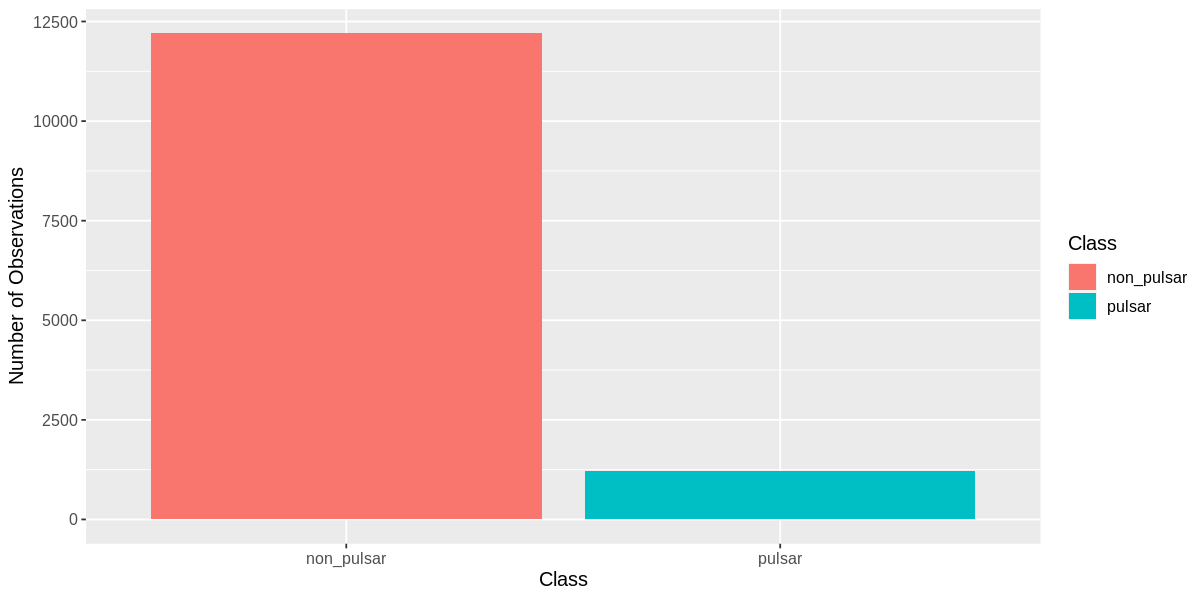

In [4]:
options(repr.plot.width = 10, repr.plot.height = 5)
class_distribution_plot_1 <- pulsar_data_train |>
                             ggplot(aes(x = class, fill = class)) +
                             geom_bar() + labs(x = "Class", y = "Number of Observations", fill = "Class") +
                             theme(text = element_text(size = 12))
class_distribution_plot_1

In [5]:
set.seed(2002)
# Balancing the classes

ups_recipe <- recipe(class ~ ., data = pulsar_data_train) |>
              step_downsample(class, under_ratio = 1, skip = FALSE) |>
              prep()

pulsar_data_training <- bake(ups_recipe, pulsar_data_train)

pulsar_data_training

id,mean_intp,std_dev_intp,xs_kurtosis_intp,skewness_intp,mean_dmsnr,std_dev_dmsnr,xs_kurtosis_dmsnr,skewness_dmsnr,class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
4029,102.4922,40.77338,0.26512930,1.5441063,8.073579,37.02852,4.680449,21.15971,non_pulsar
9546,110.4453,55.25238,0.11425968,-0.5991983,5.388796,28.04187,5.570570,31.69249,non_pulsar
11978,120.6016,39.64084,0.30622866,0.8938234,8.260870,35.10703,4.475239,20.02174,non_pulsar
11119,102.0859,47.91252,0.36011235,0.2816632,2.626254,17.03690,9.190054,98.91683,non_pulsar
12970,130.1094,55.88342,0.07224081,-0.5109587,2.569398,14.57369,8.700873,102.89946,non_pulsar
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
17460,39.95312,31.47218,3.881383,20.5227224,33.9891304,68.01901,1.9606233,2.564720,pulsar
17473,95.14844,46.66856,1.054644,1.9257564,99.3060201,102.46457,0.2734398,-1.757865,pulsar
17516,89.86719,47.48229,1.591325,2.5050565,0.7633779,12.39356,17.9407446,333.902630,pulsar


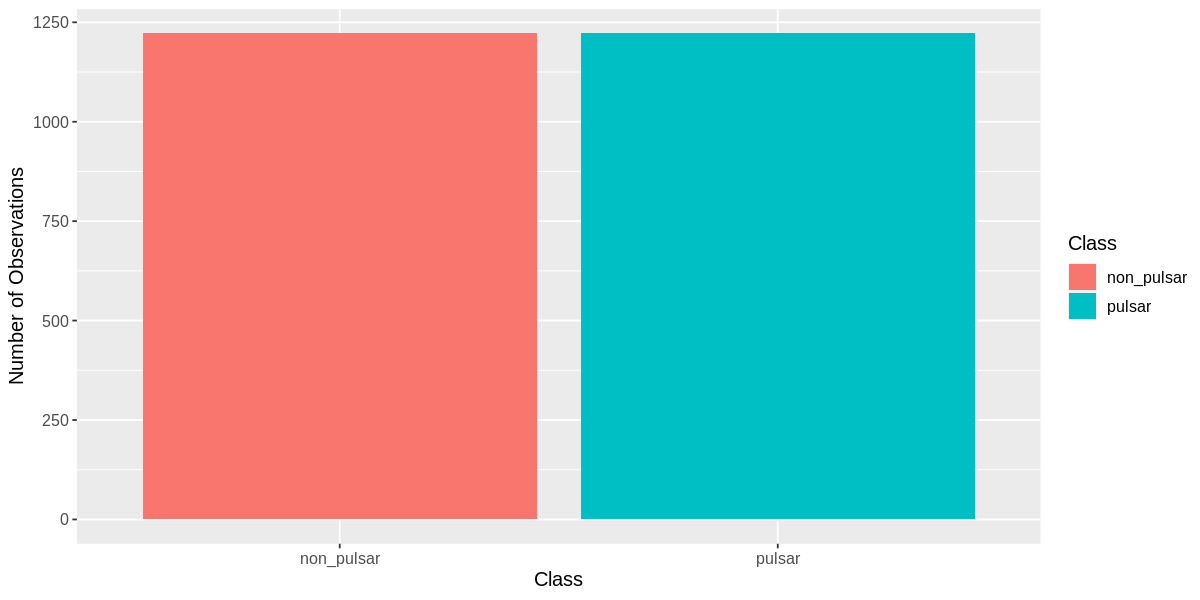

In [6]:
options(repr.plot.width = 10, repr.plot.height = 5)
class_distribution_plot <- pulsar_data_training |>
                           ggplot(aes(x = class, fill = class)) +
                           geom_bar() + labs(x = "Class", y = "Number of Observations", fill = "Class") +
                           theme(text = element_text(size = 12))
class_distribution_plot

In [7]:
# Create recipe with training data that centres and scales data
set.seed(2002)
pulsar_data_recipe <- recipe(class ~ mean_intp + std_dev_intp + xs_kurtosis_intp + skewness_intp + mean_dmsnr + std_dev_dmsnr +
                                     xs_kurtosis_dmsnr + skewness_dmsnr, data = pulsar_data_training) |>
                      step_scale(all_predictors()) |>
                      step_center(all_predictors())


In [8]:
# Create KNN model that sets neighbours to tune()
set.seed(2002)
pulsar_data_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode("classification")

In [9]:
# Create cross validation using training data
set.seed(2002)
pulsar_data_vfold <- vfold_cv(pulsar_data_training, v = 5, strata = class)


In [10]:
# Create workflow
set.seed(2002)

grid_vals <- tibble(neighbors = 1:10)

pulsar_data_results <- workflow() |>
                       add_recipe(pulsar_data_recipe) |>
                       add_model(pulsar_data_tune) |>
                       tune_grid(resamples = pulsar_data_vfold, grid = grid_vals) |>
                       collect_metrics()

In [11]:
pulsar_data_accuracy_results <- pulsar_data_results |>
                       filter(.metric == "accuracy") # Filters to only the accuracy metric.

pulsar_data_accuracy_results

pulsar_data_optimal_k <- pulsar_data_accuracy_results |>
                         filter(mean == max(mean)) |>
                         select(neighbors) |> # Gets the optimal k-value.
                         pull()

pulsar_data_optimal_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9165490,5,0.009283479,Preprocessor1_Model01
2,accuracy,binary,0.9165490,5,0.009283479,Preprocessor1_Model02
3,accuracy,binary,0.9316912,5,0.007948410,Preprocessor1_Model03
4,accuracy,binary,0.9316912,5,0.007948410,Preprocessor1_Model04
5,accuracy,binary,0.9312697,5,0.007031135,Preprocessor1_Model05
6,accuracy,binary,0.9312697,5,0.007031135,Preprocessor1_Model06
7,accuracy,binary,0.9341385,5,0.008248614,Preprocessor1_Model07
8,accuracy,binary,0.9341385,5,0.008248614,Preprocessor1_Model08
9,accuracy,binary,0.9329090,5,0.007674446,Preprocessor1_Model09


[1] 7 8

In [12]:
#using optimal K value to create the specification
set.seed(2002)
knn_specification <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |> 
                     set_engine("kknn") |> 
                     set_mode("classification")

#using the same recipe in the workflow and fit into data training

knn_fit <- workflow() |> 
                add_recipe(pulsar_data_recipe) |> 
                add_model(knn_specification) |> 
                fit(data = pulsar_data_training)

#predicting
knn_prediction <- predict(knn_fit, pulsar_data_testing) |> 
                  bind_cols(pulsar_data_testing)

knn_prediction2 <- knn_prediction |>
                   mutate(class = as_factor(class))

knn_metrics <-  knn_prediction2 |> 
                metrics(truth = class, estimate = .pred_class) |>
                filter(.metric == "accuracy")
knn_metrics



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9568715


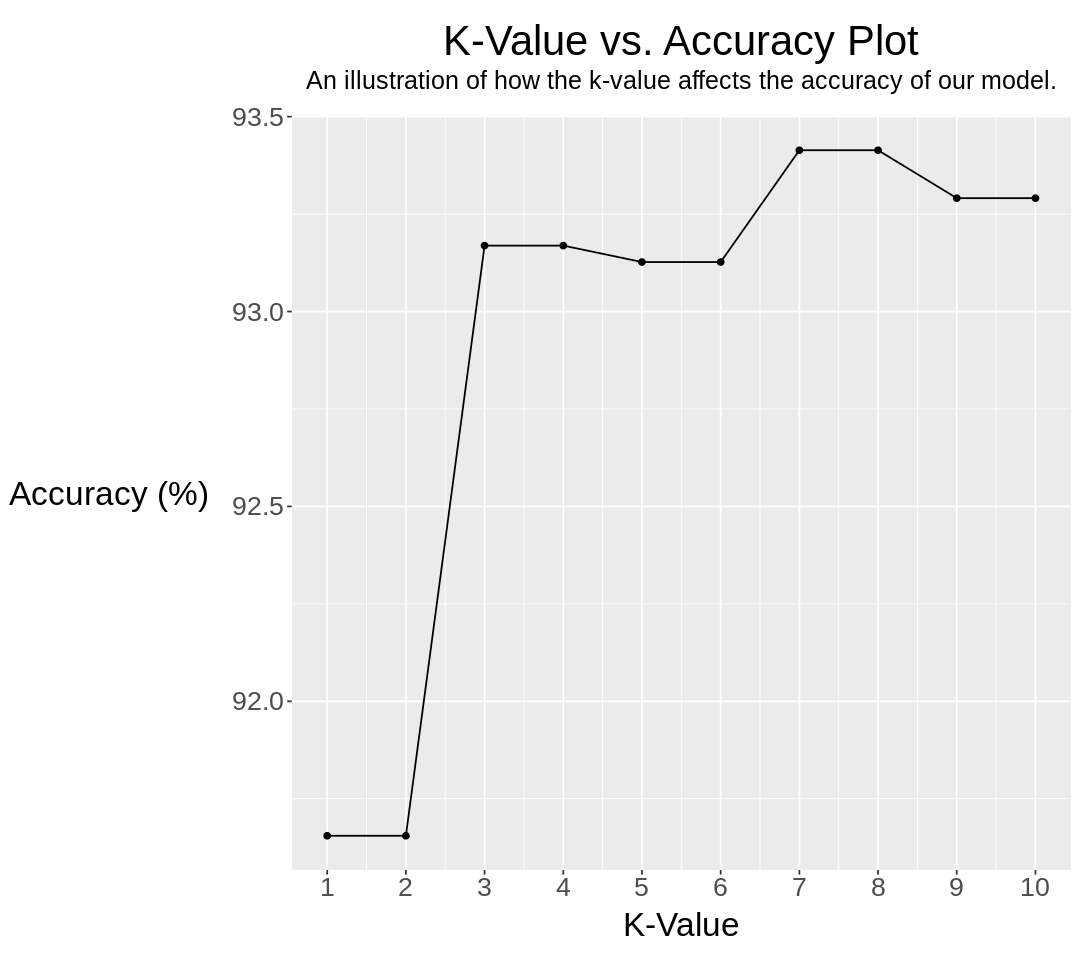

In [13]:
# Plotting the k-values vs. accuracies.

options(repr.plot.width = 9, repr.plot.height = 8) # Resize the plot.

# pulsar_data_results |>
#     filter(.metric == "accuracy") # Uncomment this to show all accuracies in a table.

pulsar_data_results_plot <- pulsar_data_results |>
                filter(.metric == "accuracy") |>
                select(neighbors, mean) |>
                mutate(mean = mean*100) |> # Converts the accuracy from a decimal to a percentage.
                ggplot(aes(x = neighbors, y = mean)) +
                geom_line() + 
                geom_point() +
                labs(x = "K-Value", 
                     y = "Accuracy (%)", 
                     title = "K-Value vs. Accuracy Plot", 
                     subtitle = "An illustration of how the k-value affects the accuracy of our model.") +
                theme(text = element_text(size=20), 
                      plot.subtitle = element_text(size=15, hjust = 0.5, margin = margin(b = 13, unit = "pt")), 
                      plot.title = element_text(size = 25, hjust = 0.5, margin = margin(t = 10, b = 5, unit = "pt")),
                      axis.title.y = element_text(size=20, angle = 0, vjust = 0.5, margin = margin(r = 13.5, unit = "pt")),
                      axis.title.x = element_text(size=20, vjust = -0.25, margin = margin(t = 2, b = 10, unit = "pt"))) + # Makes the text more readable.
                scale_x_continuous(breaks = 1:10) # Make the x-axis values go from the integers 1-10.

pulsar_data_results_plot

From the plot, we can see that the $k$-values that yield the most accurate results are 7 and 8. In this case, the $k$-value of 7 is the most optimal for our model as it is an odd number thus preventing ties from occuring when comparing the ratio of pulsars and non-pulsars during classification.